# Policy Iteration
In this notebook, you are going to implement a policy-based approach for solving a MDP, called _Policy Iteration_.

The total points of **_Policy Iteration_** implementation is **30 POINTS**.

## Import the necessary software libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gridworld import Environment
from utils import plot_policy, plot_values, test_agent

c:\Users\vamsi\miniconda3\Lib\site-packages\pygame\pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
c:\Users\vamsi\miniconda3\Lib\site-packages\pkg_resources\__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('ruamel')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


## Initialize the environment

In [2]:
env = Environment()
state = env.reset()

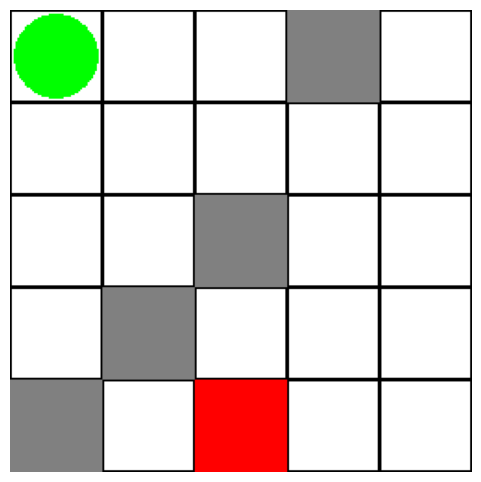

In [3]:
frame = env.render()
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(frame)

In [4]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [5]:
policy_probs = np.full((env.GH, env.GW, 4), 0.25)

In [6]:
def policy(state):
    return policy_probs[state]

#### Test the policy with state (0, 0)

In [7]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

In [8]:
# test_agent(env, policy, episodes=1)

#### Plot the policy

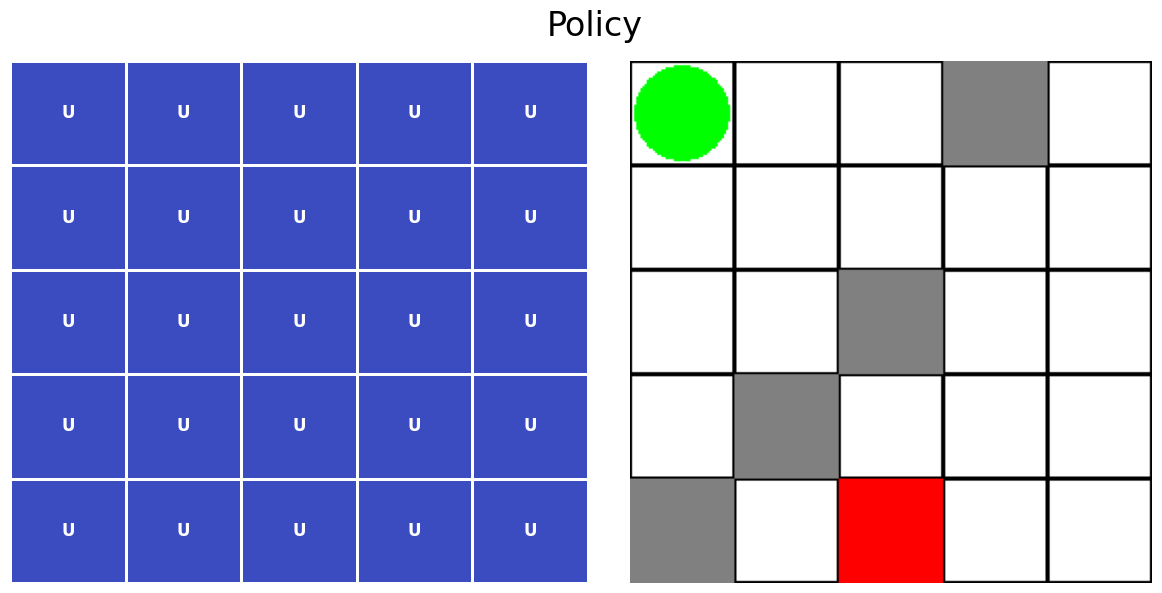

In [9]:
plot_policy(policy_probs, frame)

## Implement the Policy Iteration algorithm
<!-- <div style="text-align:center"> -->
<a target="_parent">
    <img src="policy-iteration.png" width="60%"/>
</a> 

Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
<!-- </div> -->


In [10]:
def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99):
    # Initialize the environment
    env = Environment()
    env.reset()  # Initialize the environment state

    # Repeat until convergence
    while True:
        delta = 0  # Initialize delta for tracking the maximum change in value

        # For each state in the environment
        for i in range(env.GH):
            for j in range(env.GW):
                # Skip obstacle states
                if (i, j) in env.OBSTACLES_YX:
                    continue

                # Store the old value
                v = state_values[i, j]
                new_v = 0

                # For each possible action in the current state
                for a in range(env.ACTIONS):
                    # Get the next state and reward for taking action 'a' in state (i, j)
                    next_state, reward, _, _ = env.simulate_step((i, j), a)

                    # Calculate the value of taking action 'a' in state (i, j)
                    # This is the expected value under the current policy
                    new_v += policy_probs[i, j, a] * (reward + gamma * state_values[next_state[0], next_state[1]])

                # Update the state value
                state_values[i, j] = new_v

                # Update delta with the maximum change in value
                delta = max(delta, abs(v - new_v))

        # If the maximum change in value is less than theta, we've converged
        if delta < theta:
            break

    # Return the evaluated state values
    return state_values

In [11]:
def policy_improvement(policy_probs, state_values, gamma=0.99):
    # Initialize the environment
    env = Environment()
    env.reset()  # Initialize the environment state

    # Assume the policy is stable initially
    policy_stable = True

    # Iterate through all states in the grid
    for i in range(env.GH):
        for j in range(env.GW):
            # Skip obstacle states
            if (i, j) in env.OBSTACLES_YX:
                continue

            # Get the current best action for this state
            old_action = np.argmax(policy_probs[i, j])

            # Calculate the value of each action in this state
            action_values = np.zeros(env.ACTIONS)
            for a in range(env.ACTIONS):
                # Simulate taking action 'a' in state (i, j)
                next_state, reward, _, _ = env.simulate_step((i, j), a)
                # Calculate the value of this action using the Bellman equation
                action_values[a] = reward + gamma * state_values[next_state[0], next_state[1]]

            # Find the best action based on the calculated values
            best_action = np.argmax(action_values)

            # If the best action has changed, update the policy
            if old_action != best_action:
                policy_stable = False
                # Update the policy to choose the new best action with probability 1
                policy_probs[i, j] = np.eye(env.ACTIONS)[best_action]

    # Return whether the policy has stabilized
    return policy_stable

In [12]:
def policy_iteration(policy_probs, state_values, theta=1e-3, gamma=0.99):
    # Continue iterating until the policy stabilizes
    while True:
        # Policy Evaluation: Compute the state values for the current policy
        state_values = policy_evaluation(policy_probs, state_values, theta, gamma)
        
        # Policy Improvement: Update the policy based on the new state values
        policy_stable = policy_improvement(policy_probs, state_values, gamma)
        
        # If the policy is stable (hasn't changed), we've found the optimal policy
        if policy_stable:
            break
    
    # Return the optimal state values
    return state_values

In [13]:
env = Environment()
state = env.reset()
state_values = np.zeros(shape=(env.GH,env.GW))
#TODO: You need to call the Policy Iteration algorithm here
policy_iteration(policy_probs, state_values) 

array([[92.17752772, 93.10959307, 94.05107322,  0.        , 94.05204263],
       [93.10959307, 94.05107322, 95.00206327, 95.96265928, 95.00303268],
       [87.59290049, 89.02259085,  0.        , 96.93295828, 95.96362869],
       [84.18849449,  0.        , 98.90207907, 97.91305828, 96.93392769],
       [ 0.        , 98.90207907, 99.90207907, 98.90305828, 97.91402769]])

## Show results

#### Show resulting value table $V(s)$

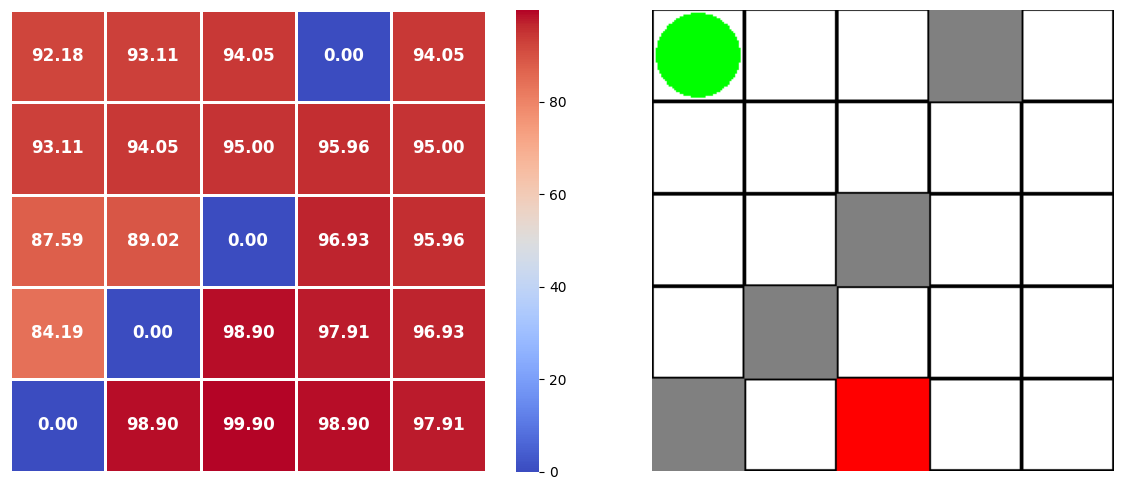

In [14]:
plot_values(state_values, frame)

#### Show resulting policy $\pi(\cdot|s)$

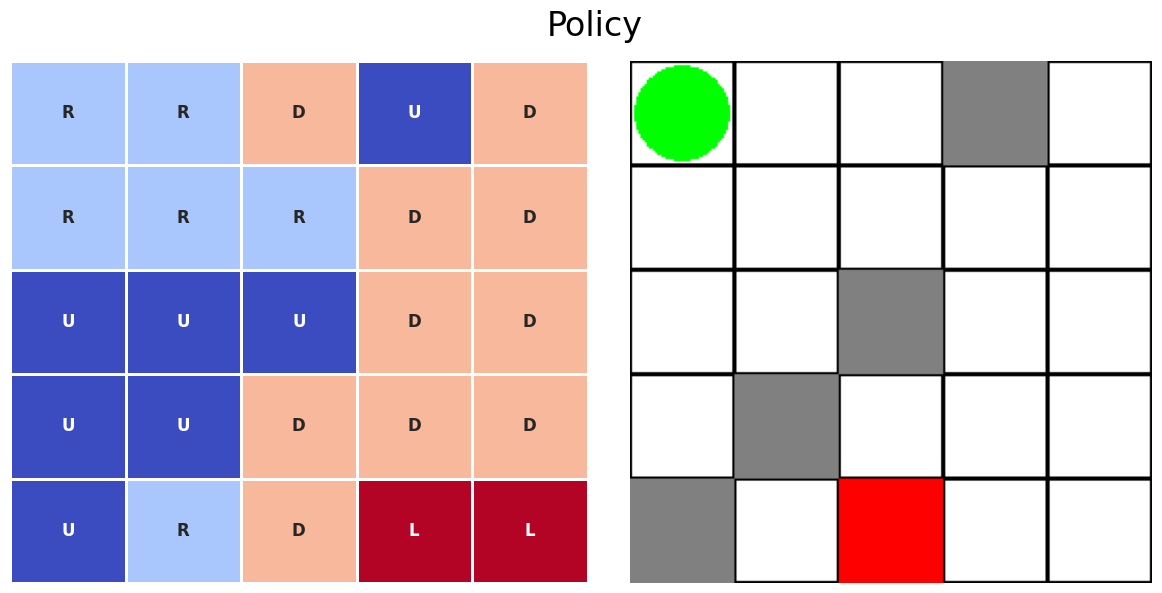

In [15]:
plot_policy(policy_probs, frame)

#### Test the resulting agent

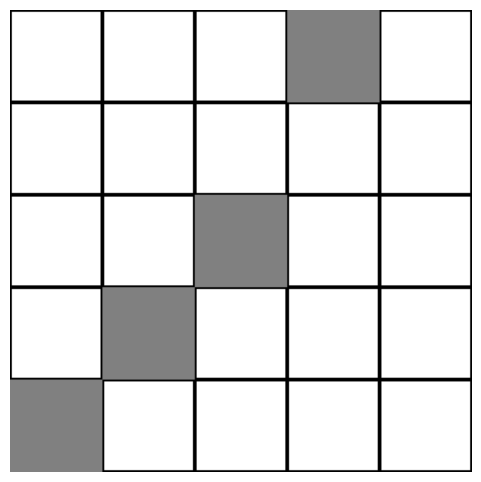

In [17]:
test_agent(env, policy, episodes=1)